In [35]:
from functools import partial
from itertools import islice
from typing import Any, Dict, List, Optional, Tuple, Union

import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import PIL
import seaborn as sns
import sklearn
import torch
import torchmetrics as tm
import wandb
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from sklearn.manifold import TSNE
from torchmetrics.functional import pairwise_euclidean_distance
from torchvision.transforms import ToPILImage

import gorillatracker.type_helper as gtypes
from gorillatracker.utils.labelencoder import LinearSequenceEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, top_k_accuracy_score, roc_auc_score, f1_score, precision_score

In [73]:
def knn_ssl(embeddings: torch.Tensor, labels: torch.Tensor, negatives: Dict[int, List[int]], k:int = 1) -> Dict[str, Any]:
    true_labels = []
    pred_labels = []
    
    for label in labels.unique():
        subset_labels = negatives[label.item()] + [label.item()]
        if(len(subset_labels) < 2):
            continue
        subset_labels = torch.tensor(subset_labels)
        subset_mask = torch.isin(labels, subset_labels)
        subset_embeddings = embeddings[subset_mask]
        subset_label_values = labels[subset_mask]
        knn = NearestNeighbors(n_neighbors=k+1,algorithm='auto').fit(subset_embeddings.numpy())
        current_label_mask = (subset_label_values == label.item())
        current_label_embeddings = subset_embeddings[current_label_mask]
        distances, indices = knn.kneighbors(current_label_embeddings.numpy())
        distances = distances[:, 1:]
        indices = indices[:, 1:]
        for idx_list in indices:
            neighbor_labels = subset_label_values[idx_list]
            most_common = torch.mode(neighbor_labels).values.item()
            true_labels.append(label.item())
            pred_labels.append(most_common)
            
    true_labels = torch.tensor(true_labels)
    pred_labels = torch.tensor(pred_labels)
    
    accuracy = accuracy_score(true_labels, pred_labels)
    #accuracy_top5 = top_k_accuracy_score(true_labels, pred_labels, k=5)
    #auroc = roc_auc_score(true_labels, pred_labels, multi_class='ovr')
    f1 = f1_score(true_labels, pred_labels, average='macro')
    precision = precision_score(true_labels, pred_labels, average='macro')
    return {'accuracy': accuracy, 'f1': f1, 'precision': precision}

In [74]:
ids = [1, 2, 3, 4, 5]
num_points_per_id = 10
grid_size = (10, 10)  # Define the grid size
np.random.seed(43)
# Generate the embeddings and labels
embeddings = []
labels = []

for id in ids:
    for _ in range(num_points_per_id):
        # Generate random x and y coordinates within the grid
        x = np.random.uniform(0, grid_size[0])
        y = np.random.uniform(0, grid_size[1])
        embeddings.append([x, y])
        labels.append(id)

# Convert the lists to Torch tensors
embeddings_tensor = torch.tensor(embeddings)
labels_tensor = torch.tensor(labels)

negatives = {1: [2, 3], 2: [1, 3], 3: [1, 2, 4], 4: [3, 5], 5: [4]}
print(knn_ssl(embeddings_tensor, labels_tensor, negatives, k=1))

{'accuracy': 0.38, 'f1': 0.38909090909090904, 'precision': 0.40499999999999997}


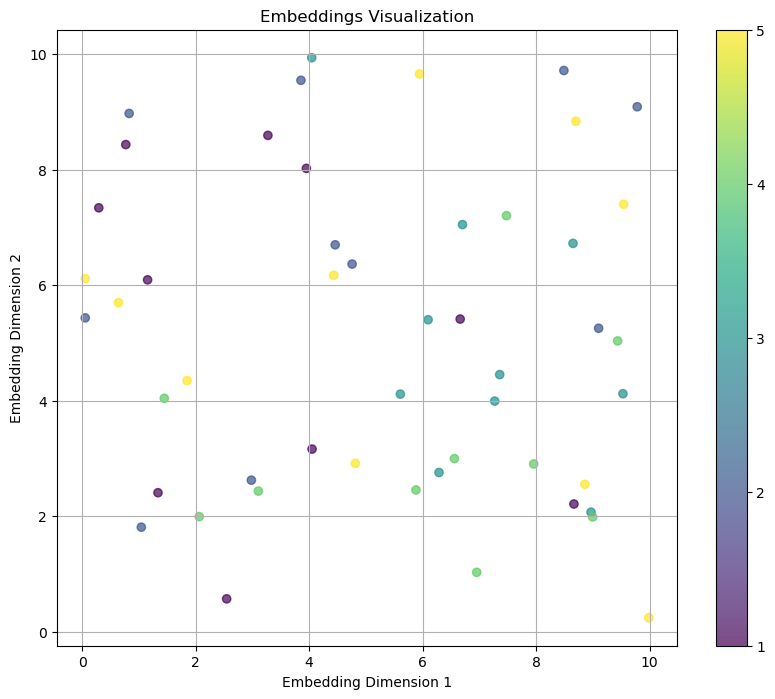

In [72]:
# Define the subset of labels we want to plot
subset_labels = [1, 2, 5, 4, 3]

# Create a mask to filter embeddings and labels
mask = torch.isin(labels_tensor, torch.tensor(subset_labels))
subset_embeddings = embeddings_tensor[mask]
subset_labels_tensor = labels_tensor[mask]

# Plotting the embeddings for the subset
plt.figure(figsize=(10, 8))
scatter = plt.scatter(subset_embeddings[:, 0], subset_embeddings[:, 1], c=subset_labels_tensor, cmap='viridis', alpha=0.7)

# Adding a colorbar and title
plt.colorbar(scatter, ticks=subset_labels)
plt.title('Embeddings Visualization')
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.grid(True)
plt.show()